In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline

In [2]:
class TimeValue:
    def __init__(self, time, value):
        self.time = time * 1.0
        self.value = value * 1.0

    def __repr__(self):
        return '({}, {})'.format(self.time, self.value)

In [3]:
class TimeSeries:
    def __init__(self, points=[]):
        self.series = []
        for (time, value) in points:
            self.append(time, value)
        
    def append(self, time, value):
        self.series.append(TimeValue(time, value))
        self.series = sorted(self.series, key=lambda x: x.time)
        
    @property
    def initial(self):
        return self.series[0]
    
    @property
    def timeline(self):
        return [x.time for x in self.series]
    
    @property
    def values(self):
        return [x.value for x in self.series]
    
    @property
    def components(self, i=None):
        try:
            return list(zip(*self.values))
        except:
            return [self.values]

    def plot(self, toggle='0', loc='best', pad=False, grid=True, marker=None, labels=None, colors=None, lw=1):
        if len(self.components) > 1:
            plt.plot(self.timeline, self.values, marker=marker)
            if loc:
                plt.legend(['x','y','z'][:len(self.components)], loc=loc, numpoints=1)
        else:
            ts = dict()
            ts['0'] = self
            ts['1'] = self.rate_of_change()
            ts['2'] = self.rate_of_change().rate_of_change()
            
            if colors is None:
                colors = [None, None, None]
            else:
                colors = colors * len(toggle) # just in case...

            if labels is None:
                labels = ['position', 'velocity', 'acceleration']
            else:
                labels += [None] * (len(toggle) - len(labels)) # just in case...

            if len(toggle) > 1:
                plt.figure(figsize=(6 * len(toggle), 4))
                
            for i, tog in enumerate(toggle):
                if len(toggle) > 1:
                    plt.subplot(1, len(toggle), toggle.index(tog) + 1)
                plt.plot(ts[tog].timeline, ts[tog].values, marker=marker, 
                         label=labels[i], color=colors[i], lw=lw)
                plt.xlabel('Time')
                if pad:
                    plt.margins(0.05)
                    dt = 0.03 * (self.timeline[-1] - self.timeline[0])
                    plt.axes().set_xlim([self.timeline[0] - dt, self.timeline[-1] + dt])
                if grid:
                    plt.grid(True)
                    plt.gca().axhline(0, c='k')
                if loc and labels[i]:
                    plt.legend(loc=loc, numpoints=1)
                            
    def plot2d(self, toggle='0', x_index=0, y_index=1, title='', colors='', labels=[],
               grid=True, pad=0.05, loc=None, markevery=0, arrows=False):
        
        x = dict()
        y = dict()
        
        r = self
        x['0'] = r.components[x_index]
        y['0'] = r.components[y_index]

        v = r.rate_of_change()
        x['1'] = v.components[x_index]
        y['1'] = v.components[y_index]

        a = v.rate_of_change()
        x['2'] = a.components[x_index]
        y['2'] = a.components[y_index]

        color = dict()
        if colors:
            for i, tog in enumerate(toggle):
                color[tog] = colors[i]
        else:
            color['0'] = 'b'
            color['1'] = 'g'
            color['2'] = 'r'            

        label = dict()
        if labels:
            for i, tog in enumerate(toggle):
                label[tog] = labels[i]
        else:
            label['0'] = 'position'
            label['1'] = 'velocity'
            label['2'] = 'acceleration'
                
        for i, tog in enumerate(toggle):
            plt.plot(x[tog], y[tog], c=color[tog], markevery=[-1], 
                     marker='o', mfc='w', mec=color[tog], mew=1)
            if markevery:
                plt.plot(x[tog][:-1], y[tog][:-1], lw=0, markevery=markevery, 
                         marker='.', mec=color[tog])
            
        plt.axes().set_aspect('equal')
        plt.margins(pad)
        if loc:
            plt.legend(numpoints=1, loc=loc, labels=labels)
        plt.title(title)
        
        if grid:
            plt.grid(True)
            plt.axes().axhline(0, c='k')
            plt.axes().axvline(0, c='k')

        if arrows:
            xmin, xmax = plt.xlim()
            ymin, ymax = plt.ylim()
            size = 0.5 * (xmax - xmin) + 0.5 * (ymax - ymin)
            head_size = {
                'head_width': 0.03 * size,
                'head_length': 0.05 * size,
            }
            if '1' in toggle:
                plt.axes().arrow(x['0'][-1], y['0'][-1], x['1'][-1], y['1'][-1], 
                                 fc=color['1'], ec=color['1'], **head_size)
            if '2' in toggle:
                plt.axes().arrow(x['0'][-1], y['0'][-1], x['2'][-1], y['2'][-1], 
                                 fc=color['2'], ec=color['2'], **head_size)
             
    @property
    def intervals(self):
        intervals = []
        for i in range(1, len(self.series)):
            intervals.append((self.series[i - 1], self.series[i]))
        return intervals    
 
    def get_interval(self, time): # closed on left [a, b)
        tmin = min(self.timeline)
        tmax = max(self.timeline)
        if time < tmin:
            return None, self.series[0]
        elif time >= tmax:
            return self.series[-1], None
        else:
            for a, b in self.intervals:
                if a.time <= time and time < b.time:
                    return a, b
    
    def rate_of_change(self):
        ts = TimeSeries()
        for i, (a, b) in enumerate(self.intervals):
            dx = b.value - a.value
            dt = b.time - a.time
            if 1 == 0:
                ts.append(a.time, dx/dt)
            else:
                ts.append(a.time + dt/2, dx/dt)
        return ts
                
    def __call__(self, time):
        a, b = self.get_interval(time)
        # this method will not extrapolate, but we do need to take care of this edge case...
        if b is None and round(a.time - time, 10) == 0:
            return a.value
        else:
            dx = b.value - a.value
            dt = b.time - a.time
            return a.value + dx/dt * (time - a.time)

    def __getitem__(self, index):
        if isinstance(index, int):
            return self.series[index]
        elif isinstance(index, slice):
            return self.series[index]
        else:
            raise TypeError("index must be int or slice")
        
    def __repr__(self):
        import pprint
        return pprint.pformat(self.series)


In [4]:
class Particle():
    def __init__(self, mass=1, t0=0, r0=None, v0=None, p0=None, dim=1):
        
        # The only purpose of the following is to redefine the defaults
        # I am *not* error-checking the input parameters...

        if isinstance(r0, np.ndarray):
            dim = max(len(r0), dim)
        if isinstance(v0, np.ndarray):
            dim = max(len(v0), dim)

        if r0 is None:
            if dim == 1:
                r0 = 0
            else:
                r0 = np.zeros(dim)
            
        if v0 is None:
            if dim == 1:
                v0 = 0
            else:
                v0 = np.zeros(dim)
                    
        self.mass = mass
        self.position = TimeSeries([(t0, r0)])
        if self.mass and p0 is None:
            self.momentum = TimeSeries([(t0, self.mass * v0)])
        else:
            self.momentum = TimeSeries([(t0, p0)])
        self.forces = {}

    def add_force(self, force, name=None):
        if name is None:
            name = len(self.forces)
        self.forces[name] = ( lambda t, obj=self: force(obj, t) )
        
    def net_force(self, time): # momentum flow or rate of change
        net_force = 0
        for name, force in self.forces.items():
            net_force += force(time)
        return net_force

    def velocity(self, time): # position flow or rate of change
        if time > max(self.momentum.timeline):
            time = max(self.momentum.timeline)
        return self.momentum(time) / self.mass

    def acceleration(self, time):
        r = self.position
        v = r.rate_of_change()
        a = v.rate_of_change()
        if time >= a.timeline[-1]:
            return a.values[-1]
        elif time <= a.timeline[0]:
            return a.values[0]
        else:
            return a(time)
    
    def increment(self, dt, n=1):
        for i in range(n):
            t = max(self.position.timeline)

            if len(self.position.timeline) == 1: # then only go forward half an increment            
                next_p = self.momentum(t) + self.net_force(t) * dt/2
                self.momentum = TimeSeries() # throw out that "initial" value
            else: # reach back half an increment to calculate the new momentum value
                next_p = self.momentum(t - dt/2) + self.net_force(t) * dt

            self.momentum.append(t + dt/2, next_p)
            next_r = self.position(t) + self.velocity(t + dt/2) * dt        
            self.position.append(t + dt, next_r)

In [5]:
class PhysicalSystem():
    def __init__(self, initial=[]):
        self.objs = list()
        for (mass, r0, v0) in initial:
            self.objs.append(Particle(mass=mass, r0=r0, v0=v0))
                    
        for obj1 in self.objs:
            for obj2 in self.objs:
                if obj1 != obj2: # no self-interactions !
                    internal_force = lambda t, obj1=obj1, obj2=obj2: self.interaction(obj1, obj2, t)
                    obj1.forces.append(internal_force)
                    
    def interaction(self, obj1, obj2, time):
        return 0
                    
    def increment(self, dt, n=1):
        for i in range(n):
            for obj in self.objs:
                obj.increment(dt)
                
    def plot(self):
        for i, obj in enumerate(self.objs):
            obj.position.plot(legend_loc=None)
            
    def plot2d(self, colors='bgrcmyk'*9, **kwargs):
        for i, obj in enumerate(self.objs):
            obj.position.plot2d(color=colors[i], **kwargs)

In [6]:
import cmath

class RigidObject(Particle):
    def __init__(self, mass=1, t0=0, r0=0, p0=0, v0=None, moi=1, q0=1+0j, L0=0+0j, w0=None):
        Particle.__init__(self, mass, t0, r0, p0, v0)
        self.moi = moi
        self.attitude = TimeSeries([(t0, q0)])
        self.angular_displacement = TimeSeries([(t0, cmath.phase(q0))])
        if self.moi and w0 is not None:
            self.angular_momentum = TimeSeries([(t0, self.moi * w0)])
        else:
            self.angular_momentum = TimeSeries([(t0, L0)])
        self.torques = []
    
    def add_torque(self, torque):
        self.torques.append(lambda t, obj=self: torque(obj, t))        
        
    def net_torque(self, time): # angular_momentum flow or rate of change
        net_torque = 0+0j
        for tau in self.torques:
            net_torque += tau(time)
        return net_torque

    def rotational_velocity(self, time): # attitude flow or rate of change
        if time > max(self.angular_momentum.timeline):
            time = max(self.angular_momentum.timeline)
        return self.angular_momentum(time) / self.moi
    
    def increment(self, dt, n=1):
        for i in range(n):
            Particle.increment(self, dt, 1)
            
            t = max(self.attitude.timeline)

            if len(self.attitude.timeline) == 1: # then only go forward half an increment            
                next_L = self.angular_momentum(t) + self.net_torque(t) * dt/2
                self.angular_momentum = TimeSeries() # throw out that "initial" value
            else: # reach back half an increment to calculate the new momentum value
                next_L = self.angular_momentum(t - dt/2) + self.net_torque(t) * dt                

                q = self.angular_displacement(t - dt)
                q += self.rotational_velocity(t + dt/2) * dt
                self.angular_displacement.append(t, q)

            self.angular_momentum.append(t + dt/2, next_L)
            rotor = np.exp( 1j * self.rotational_velocity(t + dt/2) * dt )
            next_attitude = self.attitude(t) * rotor
            self.attitude.append(t + dt, next_attitude)

- Ch 01: 1,3,5,12,13,45,46,49,59,61
- Ch 02: 1,3,15,28,29,45,51,53,67,68,78,79,81
- Ch 03: 5,7,8,9,19,30,35,57,59,69,71
- Ch 04: 1,11,38,39,42,56,79,81,98,103,104
- Ch 05: 5,7,8,9,15,23,27,31,41,52,56
- Ch 06: 3,5,6,8,13,19,29,33,38,41,64,68,77
- Ch 07: 1,5,7,19,21,29,31,33,35,41
- Ch 08: 1,3,9,21,23,25,37,39,42,53,54,56,68,69
- Ch 09: 1,6,12,15,31,33,34,48,51,63,64,71,73

## Chapter 4

In [8]:
def vmag(a):
    vmag = np.sqrt( a[0] ** 2 + a[1] ** 2 )
    return vmag

def vdir(a):
    if vmag(a) == 0:
        vdir = np.array([1,0]) # it doesn't matter since magnitude = 0
    else:
        vdir = a / vmag(a)
    return vdir
        
def vang(a, deg=True):
    vang = np.arctan2(a[1], a[0])
    if deg:
        vang = vang * 180/np.pi
    return vang

def vect(mag, ang, deg=True):
    if deg:
        ang = ang * np.pi/180
    return mag * np.array([np.cos(ang), np.sin(ang)])

def vdot(a, b):
    assert len(a) == len(b)
    vdot = 0
    for i in range(len(a)):
        vdot += a[i] * b[i]
    return vdot

In [9]:
def weight(obj):
    return np.array([0, -9.8 * obj.mass])

def support(obj, normal=np.array([0,1])):
    net_force = obj.net_force(t)
    net_force_proj = vdot(net_force, normal)
    support = -net_force_proj * normal
    return support

def friction(obj, support, mu_s=1, mu_k=1):
    net_force = obj.net_force(t)
    v = obj.velocity(t)
    
    frickin = False
    if vmag(v) > 0:
        frickin = True
    if vmag(net_force) > mu_s * vmag(support): # maximum static friction
        frickin = True
        
    if frickin: # then use kinetic friction
        friction = -mu_k * vmag(support) * vdir(v)
    else: # create equilibrium
        friction = -net_force
        
    return friction

**Problem 001**

An airplane has a mass of 31,000 kilograms and takes off under the influence of a constant net force of 37,000 newtons. What is the net force that acts on the 78-kilogram pilot?

*Answer:* 93 newtons

In [10]:
mass_of_plane = 31000
mass_of_pilot = 78

momentum_flow_to_whole = 37000
ratio_of_part_to_whole = mass_of_pilot / mass_of_plane
momentum_flow_to_part = momentum_flow_to_whole * ratio_of_part_to_whole
print('a. Momentum flow to pilot = {:.1f} kg-m/s per second'.format(momentum_flow_to_part))

force_on_plane = 37000
acceleration_of_plane = force_on_plane / mass_of_plane
acceleration_of_pilot = acceleration_of_plane
force_on_pilot = mass_of_pilot * acceleration_of_pilot
print('b. Force on pilot = {:.1f} newtons'.format(force_on_pilot))

a. Momentum flow to pilot = 93.1 kg-m/s per second
b. Force on pilot = 93.1 newtons


**Problem 011**

Only two forces act on an object (mass = 3.00 kilograms), as in the drawing. Find the magnitude and direction (relative to the `x` axis) of the acceleration of the object.

*Answer:* 30.9 m/s² at 27.2°

The acceleration is 30.9 m/s² at 27.2°


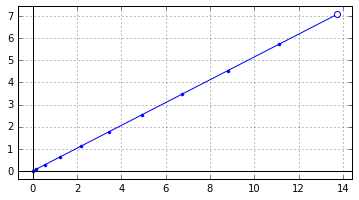

In [11]:
force1 = vect(mag=40, ang=0)
force2 = vect(mag=60, ang=45)

obj = Particle(mass=3, dim=2)
obj.add_force(lambda obj, t: force1)
obj.add_force(lambda obj, t: force2)
obj.increment(0.1, 10)

t = obj.position.timeline[-1]
a = obj.acceleration(t)
mag = vmag(a)
ang = vang(a)

print('The acceleration is {:.1f} m/s² at {:.1f}°'.format(mag, ang))

obj.position.plot2d(markevery=1)

**Problem 038**

A 35-kilogram crate rests on a horizontal floor, and a 65-kilogram person is standing on a crate. Determine the magnitude of the normal force that (a) the floor exerts on the crate and (b) the crate exerts on the person.

*Answer:* (a) 980 newtons (b) 640 newtons

In [12]:
weight_of_crate = 35 * 9.8
weight_of_person = 65 * 9.8
total_weight = weight_of_crate + weight_of_person

'''
Momentum flows into the person due to his/her weight. However, none of this momentum remains in the body. How 
do we know that? Because it does not move. Where does it go? It must go into the crate. 

The crate also receives momentum due to its weight. But the crate doesn't move either. So all of this momentum 
must be shed to the floor.

Fine --- but this describes the force the crate exerts on the floor. Downward momentum (from weight) flows
down from person to crate to floor. Compression results when momentum flows in the direction it points.

Compression works both ways. What is the opposite of downward momentum? Upward momentum. The floor supports the
crate (and person). Said differently, the floor supplies an *upward* force --- which implies that the floor
supplies upward momentum to the crate.

How do we reconcile this? Here is the key: we consider upward momentum flowing up *the same as* downward 
momentum flowing down. The two opposites senses cancel. Be careful: we do not have two different flows that 
cancel. No, we have one momentum flow described two different ways.

This is true in general. The flow of a quantity is equivalent to flow in the opposite direction of the opposite 
quantity. The most common form of flow, mass flow, cannot be considered this way since mass does not have an
opposite, but electric charge does. This principle of momentum flow is Newton's 3rd law. 

This shows how Newton's third law works in this case and why the force the floor exerts on the crate is equal
to the weight of both the crate and the person. 

Continuing the (separate) analysis from this perspective, this total upward momentum flows up into the crate. 
The downward momentum from its weight cancels out some of this upward flow. The remainder makes it up to the 
top of the crate and flows into the person. This remainder is exactly canceled by the weight of the person.
'''

print('The force of the floor on the crate = {:.0f} newtons'.format(total_weight))
print('The force of the crate on the person = {:.0f} newtons'.format(weight_of_person))
print('')
print('Said differently...')
print('')
print('The momentum flow to the crate from the floor = {:.0f} kg-m/s per second'.format(total_weight))
print('The momentum flow to the person from the crate = {:.0f} kg-m/s per second'.format(weight_of_person))

The force of the floor on the crate = 980 newtons
The force of the crate on the person = 637 newtons

Said differently...

The momentum flow to the crate from the floor = 980 kg-m/s per second
The momentum flow to the person from the crate = 637 kg-m/s per second


**Problem 039**

A 60.0-kilogram crate rests on a level floor at a shipping dock. The coefficients of static and kinetic friction are 0.760 and 0.410, respectively. What horizontal pushing force is required to (a) just start the crate moving and (b) slide the crate across the dock at a constant speed?

*Answer:* (a) 447 newtons (b) 241 newtons

In [13]:
for v0 in [0,1]:
    mag_ext_force = 0
    for dF in [100, 10, 1, 0.1]:
        while True:
            mag_ext_force += dF

            obj = Particle(mass=60, v0=np.array([v0,0]))
            obj.add_force(lambda obj, t: weight(obj))
            obj.add_force(lambda obj, t: np.array([mag_ext_force, 0]))

            t = obj.position.timeline[-1]
            
            x = support(obj)
            obj.add_force(lambda obj, t: x)

            y = friction(obj, support=x, mu_s=0.760, mu_k=0.410)
            obj.add_force(lambda obj, t: y)
            
            obj.increment(0.1,10)

            ax, ay = obj.acceleration(t)

            if ax > 0.00001:
                break

        mag_ext_force -= dF 

    if v0 == 0:
        movsta = 'static'
    else:
        movsta = 'moving'
        
    print('Pushing force ({}) = {:.0f} newtons'.format(movsta, mag_ext_force))

Pushing force (static) = 447 newtons
Pushing force (moving) = 241 newtons


**Problem 042**

A woman stands on a scale in a moving elevator. Her mass is 60.0 kilograms, and the combined mass of the elevator and the scale is an additional 815 kilograms. Starting from rest, the elevator accelerates upward. During the acceleration, the hoisting cable applies a force of 9410 newtons. What does the scale read during the acceleration?

*Answer:* 645 newtons

In [14]:
mag_support = 0
for dF in [100, 10, 1, 0.1, 0.01, 0.001]:
    while True:
        mag_support += dF
        support_force = np.array([0,mag_support])
        
        obj1 = Particle(mass=60) # woman
        obj1.add_force(lambda obj, t: weight(obj1))
        obj1.add_force(lambda obj, t: support_force)

        obj2 = Particle(mass=815) # elevator
        obj2.add_force(lambda obj, t: weight(obj2))
        obj2.add_force(lambda obj, t: np.array([0, 9410])) # pulling force
        obj2.add_force(lambda obj, t: -support_force)

        obj1.increment(0.1,10)
        obj2.increment(0.1,10)

        t = obj1.position.timeline[-1]
        vf1x, vf1y = obj1.velocity(t)
        vf2x, vf2y = obj2.velocity(t)
        
        if vf1y > vf2y:
            break

    mag_support -= dF

a1 = vmag(obj1.acceleration(t))
a2 = vmag(obj2.acceleration(t))

print('The acceleration of the woman and the elevator are {:.2f} and {:.2f} m/s² respectively'.format(a1, a2))
print('The support force (which is the measured weight) is {:.0f} newtons'.format(mag_support))
print('But her actual weight is {:.0f} newtons'.format(vmag(weight(obj1))))

The acceleration of the woman and the elevator are 0.95 and 0.95 m/s² respectively
The support force (which is the measured weight) is 645 newtons
But her actual weight is 588 newtons


**Problem 056**

Part (a) of the drawing shows a bucket of water suspended from the pulley of a well; the tension in the rope is 92.0 newtons. Part (b) shows the same bucket of water being pulled up from the well at a constant velocity. What is the tension in the rope in part (b)?

*Answer:* 184 newtons

In [15]:
mag_weight = 0
for dF in [1000, 100, 10, 1, 0.1, 0.01]:
    while True:
        mag_weight += dF
        
        obj = Particle()
        obj.add_force(lambda obj, t: 92)
        obj.add_force(lambda obj, t: 92)
        obj.add_force(lambda obj, t: -mag_weight)
        
        obj.increment(0.1,10)
        
        a = obj.acceleration(t)
        if a < 0:
            break
            
    mag_weight -= dF
    
print('(a) Weight of bucket = {:.0f} newtons'.format(mag_weight))

mag_tension = 0
for dF in [1000, 100, 10, 1, 0.1, 0.01]:
    while True:
        mag_tension += dF
        
        obj = Particle()
        obj.add_force(lambda obj, t: mag_tension)
        obj.add_force(lambda obj, t: -mag_weight)
        
        obj.increment(0.1,10)
        
        a = obj.acceleration(t)
        if a > 0:
            break
            
    mag_tension -= dF
    
print('(b) Final tension = {:.0f} newtons'.format(mag_tension))

(a) Weight of bucket = 184 newtons
(b) Final tension = 184 newtons


**Problem 079**

A student is skateboarding down a ramp that is 6.0 meters long and inclined at 18° with respect to the horizontal. The initial speed of the skateboarder at the top of the ramp is 2.6 m/s. Neglect friction and find the speed at the bottom of the ramp.

*Answer:* 6.6 m/s

Final position = 6.00 meters
Final velocity = 6.57 m/s
Final acceleration = 3.03 m/s²


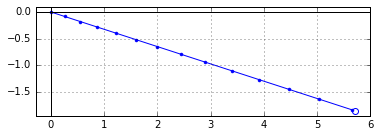

In [16]:
mag = 2.6
ang = -18 * np.pi/180
v0 = mag * np.array([np.cos(ang), np.sin(ang)])

ang += np.pi/2
ramp_normal = np.array([np.cos(ang), np.sin(ang)])

for dt in [0.001]:
    obj = Particle(v0=v0)
    obj.add_force(lambda obj, t: weight(obj))
    
    t = obj.position.timeline[-1]
    x = support(obj, ramp_normal)

    obj.add_force(lambda obj, t: x)
    
    while True:
        obj.increment(dt)
        r = vmag(obj.position.values[-1])
        if r > 6.0:
            break

t = obj.position.timeline[-1]
v = vmag(obj.velocity(t))
a = vmag(obj.acceleration(t))
            
print('Final position = {:.2f} meters'.format(r))
print('Final velocity = {:.2f} m/s'.format(v))
print('Final acceleration = {:.2f} m/s²'.format(a))

obj.position.plot2d(markevery=100)

**Problem 081**

A 205-kilogram log is pulled by a ramp by means of a rope that is parallel to the surface of the ramp. The ramp is inclined at 30.0° with respect to the horizontal. The coefficient of kinetic friction between the log and the ramp is 0.900, and the log has an acceleration of magnitude 0.800 m/s². Find the tension in the rope.

*Answer:* 2730 newtons

Final acceleration = 0.80 m/s²
Final tension = 2734 newtons


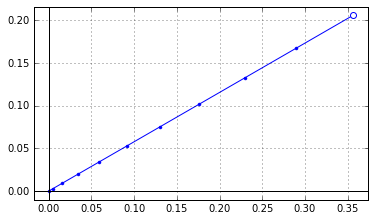

In [17]:
ramp_ang = 30
ramp_normal = vect(1, ramp_ang + 90)

mag_tension = 0
for dF in [1000, 100, 10, 1]:
    while True:
        mag_tension += dF
        
        v0 = vect(0.01, ramp_ang)
        obj = Particle(mass=205, v0=v0)
        obj.add_force(lambda obj, t: weight(obj))

        tension = vect(mag_tension, ramp_ang)
        obj.add_force(lambda obj, t: tension)

        x = support(obj, normal=ramp_normal)
        obj.add_force(lambda obj, t: x)

        y = friction(obj, support=x, mu_k=0.900)
        obj.add_force(lambda obj, t: y)
        
        obj.increment(0.1,10)
        
        t = obj.position.timeline[-1]
        a = vmag(obj.acceleration(t))
        ax, ay = obj.acceleration(t)
        if ax > 0 and a > 0.8:
            break
            
    mag_tension -= dF
    
print('Final acceleration = {:.2f} m/s²'.format(a))
print('Final tension = {:.0f} newtons'.format(mag_tension))

obj.position.plot2d(markevery=1)

**Problem 098**

Two forces, `F1` and `F2`, act on the 7.00-kilogram block shown in the drawing. The magnitudes of the forces are 59.0 newtons and 33.0 newtons, respectively. What is the horizontal acceleration (magnitude and direction) of the block?

*Answer:* 1.83 m/s² to the left

In [18]:
force1 = vect(mag=59,ang=-70,deg=True)
force2 = vect(mag=33,ang=180,deg=True)

obj = Particle(mass=7)
obj.add_force(lambda obj, t: force1)
obj.add_force(lambda obj, t: force2)

obj.increment(0.1,10)

ax, ay = obj.acceleration(1)

print('Horizontal acceleration = {:.2f} m/s²'.format(ax))

Horizontal acceleration = -1.83 m/s²


**Problem 103**

A 1380-kilogram car is moving due east with an initial speed of 27.0 m/s. After 8.00 seconds the car has slowed down to 17.0 m/s. Find the magnitude and direction of the net force that provides the deceleration.

*Answer:* 1730 newtons due west

In [19]:
pushing_force = 0
for dF in [100, 10, 1, 0.1]:
    while True:
        pushing_force -= dF
        obj = Particle(mass=1380,v0=27)
        obj.add_force(lambda obj, t: pushing_force)
        obj.increment(0.1,80)
        
        t = obj.position.timeline[-1]
        v = obj.velocity(t)
        if v < 17:
            break
            
    pushing_force += dF
    
print('Final velocity = {:.1f} m/s'.format(v))
print('Pushing force = {:.0f} newtons'.format(pushing_force))

Final velocity = 17.0 m/s
Pushing force = -1736 newtons


**Problem 104**

When a 58-gram tennis ball is served, it accelerates from rest to a speed of 45 m/s. The impact with the racket gives the ball a constant acceleration over a distance of 44 centimeters. What is the magnitude of the net force acting on the ball?

*Answer:* 130 newtons

In [20]:
pushing_force = 0
for dF in [100, 10, 1, 0.1, 0.01]:
    while True:
        pushing_force += dF
        obj = Particle(mass=0.058,v0=0)
        obj.add_force(lambda obj, t: pushing_force)
        while True:
            obj.increment(0.0001)
            r = obj.position.values[-1]
            if r > 0.44:
                break
        
        t = obj.position.timeline[-1]
        v = obj.velocity(t)
        
        if v > 45:
            break
            
    pushing_force -= dF
    
print('Final position = {:.3f} meters'.format(r))
print('Final velocity = {:.1f} m/s'.format(v))
print('Pushing force = {:.1f} newtons'.format(pushing_force))

Final position = 0.442 meters
Final velocity = 45.0 m/s
Pushing force = 133.5 newtons
